In [ ]:
%load_ext autoreload
%autoreload 2
    
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import matplotlib.pyplot as plt
from glyphosate_resistant.preprocess import extract_species_abundance,expand_taxonomic_column
from glyphosate_resistant.postprocess import load_deepec_results,summarize_ec_completeness,summarize_genus_completion,plot_genus_completion_horizontal,stacked_bar_multiple_group

In [79]:
species_top_general =  pd.read_csv("../data/processed/top_species_all.tsv", sep = "\t")
species_top_asd =  pd.read_csv("../data/processed/top_species_ASD.tsv", sep = "\t")
species_top_ctrl =  pd.read_csv("../data/processed/top_species_Control.tsv", sep = "\t")

species_top_general['Status'] = 'general'
species_top_asd['Status'] = 'asd'
species_top_ctrl['Status'] = 'ctrl'

In [3]:
enzymes = {
    "aroF_G_H": "2.5.1.54",
    "aroB": "4.2.3.4",
    "aroD": "4.2.1.10",
    "aroE": "1.1.1.25",
    "aroK_L": "2.7.1.71",
    "aroA": "2.5.1.19",
    "aroC": "4.2.3.5"
}

In [48]:
combined_result_contorl = load_deepec_results("../data/result/Ctrl/*/DeepECv2_result.txt")
combined_result_asd= load_deepec_results("../data/result/ASD/*/DeepECv2_result.txt")
combined_result_general = load_deepec_results("../data/result/general/*/DeepECv2_result.txt")
    

In [49]:
combined_result_contorl

,sequence_ID,prediction,EC number,Species
0,WP_003808114.1,None,NaN,Bifidobacterium_longum
1,WP_003808136.1,None,NaN,Bifidobacterium_longum
2,WP_003812809.1,None,NaN,Bifidobacterium_longum
3,WP_003813881.1,None,NaN,Bifidobacterium_longum
4,WP_003814508.1,None,NaN,Bifidobacterium_longum
...,...,...,...,...
216086,DBGABJ010000503.1_7,None,NaN,Phocaeicola_plebeius
216087,DBGABJ010000503.1_8,None,NaN,Phocaeicola_plebeius
216088,DBGABJ010000504.1_1,EC:5.2.1.8,5.2.1.8,Phocaeicola_plebeius
216089,DBGABJ010000504.1_2,EC:5.2.1.8,5.2.1.8,Phocaeicola_plebeius


In [51]:
summary_df_ctrl = summarize_ec_completeness(combined_result_contorl, enzymes,'control')
summary_df_asd = summarize_ec_completeness(combined_result_asd, enzymes,'ASD')
summary_df_general = summarize_ec_completeness(combined_result_general, enzymes,'general')
#sum(summary_df_general['Completeness (%)']==100)/len(summary_df_general.index)

In [53]:
summary_df_general

,Species,Detected ECs,Completeness (%),Status
34,Coprococcus_comes,"{4.2.1.10, 4.2.3.5, 4.2.3.4, 2.5.1.54, 2.5.1.1...",100.000000,general
28,Blautia_wexlerae,"{4.2.1.10, 1.1.1.25, 4.2.3.5, 2.5.1.19, 2.5.1....",100.000000,general
31,Clostridiales_bacterium_KLE1615,"{4.2.1.10, 1.1.1.25, 4.2.3.5, 2.5.1.54, 2.5.1....",100.000000,general
33,Coprococcus_catus,"{4.2.1.10, 1.1.1.25, 4.2.3.5, 2.5.1.54, 2.5.1....",100.000000,general
69,Ruminococcus_gnavus,"{4.2.1.10, 4.2.3.5, 4.2.3.4, 2.5.1.54, 2.5.1.1...",100.000000,general
...,...,...,...,...
20,Bifidobacterium_bifidum,"{4.2.1.10, 4.2.3.5, 2.5.1.54, 2.5.1.19, 1.1.1.25}",71.428571,general
19,Bifidobacterium_adolescentis,"{4.2.1.10, 4.2.3.5, 2.5.1.54, 2.5.1.19, 1.1.1.25}",71.428571,general
61,Romboutsia_timonensis,"{2.5.1.19, 2.5.1.54, 4.2.3.4, 4.2.3.5}",57.142857,general
77,Vescimonas_coprocola,"{2.5.1.19, 4.2.1.10, 2.7.1.71, 4.2.3.4}",57.142857,general


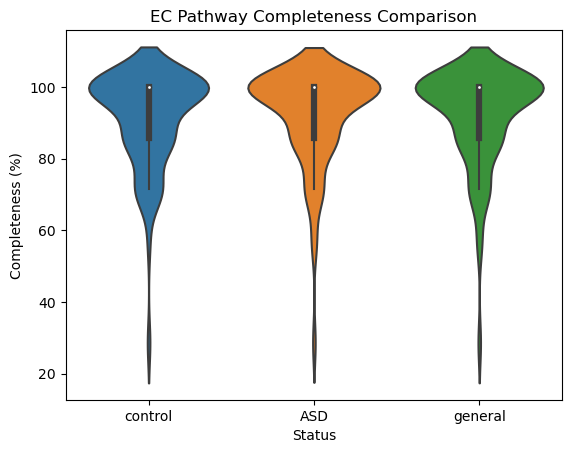

In [54]:


combined_df = pd.concat([summary_df_ctrl, summary_df_asd, summary_df_general], ignore_index=True)

# Violin plot
sns.violinplot(data=combined_df, x='Status', y='Completeness (%)', inner='box')
plt.title('EC Pathway Completeness Comparison')
plt.show()

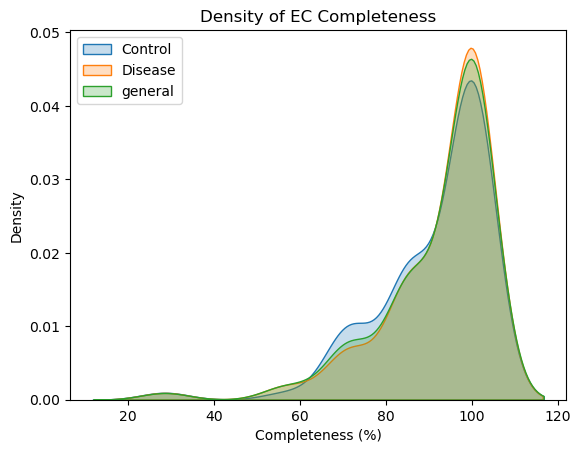

In [47]:
sns.kdeplot(summary_df_ctrl['Completeness (%)'], label='Control', fill=True)
sns.kdeplot(summary_df_asd['Completeness (%)'], label='Disease', fill=True)
sns.kdeplot(summary_df_general['Completeness (%)'], label='general', fill=True)

plt.title('Density of EC Completeness')
plt.xlabel('Completeness (%)')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()


In [50]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(summary_df_ctrl['Completeness (%)'], summary_df_asd['Completeness (%)'])
print(f"Mann-Whitney U p-value: {p:.4f}")

Mann-Whitney U p-value: 0.4931


In [58]:
abudance = pd.read_csv("../data/raw/Internal2_metaphlan_merged_abundance_table.txt",sep="\t", comment='#')


,clade_name,001-00-54-1A_CP05063_L001_taxonomic,001-00-54-2A_CP05063_L001_taxonomic,001-0001-1_CP05063_L001_taxonomic,001-0002-1_CP05063_L001_taxonomic,001-0003-1_CP05063_L001_taxonomic,001-0006-1_CP05063_L001_taxonomic,001-0007-1_CP05063_L001_taxonomic,001-0009-1_CP05063_L001_taxonomic,001-0010-1_CP05063_L001_taxonomic,...,001-0046-2A_CP05063_L001_taxonomic,001-0046-3A_CP05063_L001_taxonomic,001-0047-1A_CP05063_L001_taxonomic,001-0047-2A_CP05063_L001_taxonomic,001-0048-1A_CP05063_L001_taxonomic,001-0048-2A_CP05063_L001_taxonomic,001-0049-1A_CP05063_L001_taxonomic,001-0049-2A_CP05063_L001_taxonomic,001-0050-1A_CP05063_L001_taxonomic,001-0050-3A_CP05063_L001_taxonomic
0,k__Bacteria,100.00000,100.00000,100.00000,100.00000,100.00000,100.00000,100.00000,99.46706,99.61474,...,100.00000,100.00000,99.97867,99.99409,100.00000,100.00000,100.00000,100.00000,100.00000,100.00000
1,k__Bacteria|p__Firmicutes,73.19517,74.10209,55.44954,70.66728,83.33067,63.51207,81.65593,76.88603,69.35166,...,79.94760,49.82023,56.78614,68.05311,63.61839,72.78653,55.92025,60.04582,92.50415,94.00877
2,k__Bacteria|p__Bacteroidetes,16.58632,10.91546,14.71386,3.64369,9.99965,2.19487,7.69575,15.60081,15.48440,...,2.08390,3.04392,6.47729,2.47051,1.51529,6.23866,7.20032,22.88448,5.14532,3.14258
3,k__Bacteria|p__Actinobacteria,9.54150,14.39914,29.12784,12.44703,6.11496,33.58173,10.16868,5.89229,13.84410,...,17.60852,44.40657,36.10470,28.25065,34.14867,20.39626,34.61786,16.81498,1.70168,0.96568
4,k__Bacteria|p__Proteobacteria,0.67701,0.58331,0.70875,0.28800,0.03753,0.45494,0.08886,1.08792,0.93458,...,0.01225,0.03320,0.07446,0.17465,0.00312,0.57856,0.07887,0.25473,0.64885,1.88297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2668,k__Bacteria|p__Firmicutes|c__CFGB76102|o__OFGB...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00911,0.02716
2669,k__Bacteria|p__Firmicutes|c__Tissierellia|o__T...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00763,0.00000
2670,k__Bacteria|p__Proteobacteria|c__Deltaproteoba...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.68701
2671,k__Bacteria|p__Proteobacteria|c__Deltaproteoba...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.68701


In [60]:
collapsed_abundance = expand_taxonomic_column(abudance)
#collapsed_abundance.to_csv("../data/processed/full_collapsed_abundance.csv")

       kingdom          phylum                class               order  \
0     Bacteria             NaN                  NaN                 NaN   
1     Bacteria      Firmicutes                  NaN                 NaN   
2     Bacteria   Bacteroidetes                  NaN                 NaN   
3     Bacteria  Actinobacteria                  NaN                 NaN   
4     Bacteria  Proteobacteria                  NaN                 NaN   
...        ...             ...                  ...                 ...   
2668  Bacteria      Firmicutes            CFGB76102           OFGB76102   
2669  Bacteria      Firmicutes         Tissierellia      Tissierellales   
2670  Bacteria  Proteobacteria  Deltaproteobacteria  Desulfovibrionales   
2671  Bacteria  Proteobacteria  Deltaproteobacteria  Desulfovibrionales   
2672  Bacteria  Proteobacteria  Deltaproteobacteria  Desulfovibrionales   

                   family         genus                species    strain  
0                     Na

In [67]:
df_disease = summary_df_asd.merge(species_top_asd, on="Species")
df_ctrl = summary_df_ctrl.merge(species_top_ctrl, on="Species")
df_general = summary_df_general.merge(species_top_general, on="Species")

df_all = pd.concat([df_disease, df_ctrl, df_general])
df_all["Importance"] = df_all["Completeness (%)"] * df_all["Average_Abundance"]


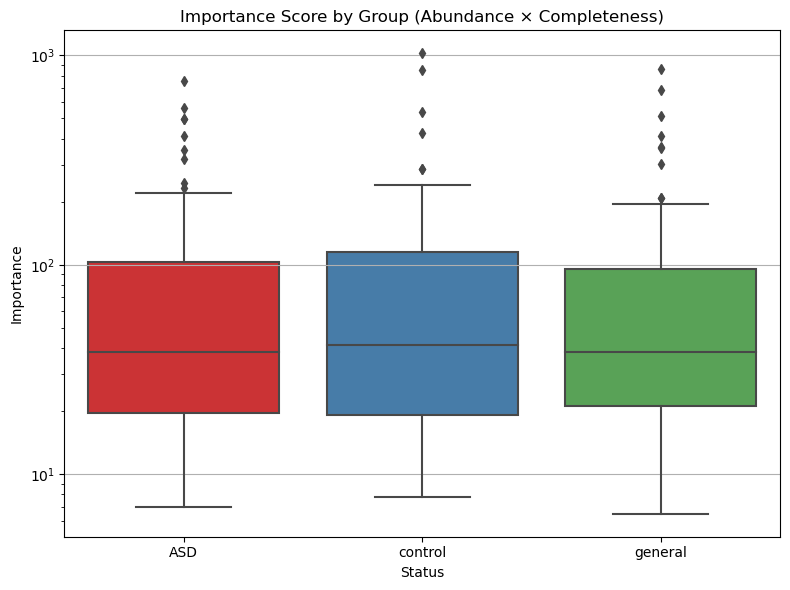

In [69]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_all, x="Status", y="Importance", palette="Set1")
plt.title("Importance Score by Group (Abundance × Completeness)")
plt.ylabel("Importance")
plt.yscale("log")  # If skewed
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

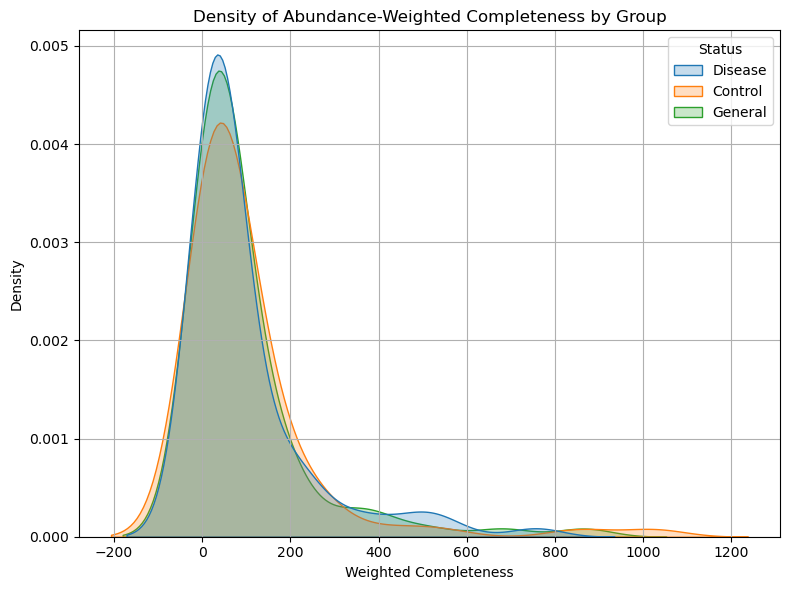

In [56]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df_all, x="Importance", hue="Status", fill=True, common_norm=False)
plt.title("Density of Abundance-Weighted Completeness by Group")
plt.xlabel("Weighted Completeness")
plt.grid(True)
plt.tight_layout()
plt.show()

In [70]:

asd_taxa = collapsed_abundance.merge(species_top_asd, left_on="species", right_on = "Species",how="right")
ctrl_taxa = collapsed_abundance.merge(species_top_ctrl, left_on="species", right_on = "Species",how="right")
general_taxa = collapsed_abundance.merge(species_top_general, left_on="species", right_on = "Species",how="right")
combine_taxa = pd.concat([asd_taxa,ctrl_taxa,general_taxa])

In [81]:
general_taxa_completeness = general_taxa.merge(df_general)
ctrl_taxa_completeness = ctrl_taxa.merge(df_ctrl)
asd_taxa_completeness = asd_taxa.merge(df_disease)

In [82]:
combine_taxa

,clade_name,001-00-54-1A_CP05063_L001_taxonomic,001-00-54-2A_CP05063_L001_taxonomic,001-0001-1_CP05063_L001_taxonomic,001-0002-1_CP05063_L001_taxonomic,001-0003-1_CP05063_L001_taxonomic,001-0006-1_CP05063_L001_taxonomic,001-0007-1_CP05063_L001_taxonomic,001-0009-1_CP05063_L001_taxonomic,001-0010-1_CP05063_L001_taxonomic,...,kingdom,phylum,class,order,family,genus,species,strain,Species,Average_Abundance
0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eub...,2.21319,1.89210,2.44589,6.46754,15.25314,0.09066,20.26919,6.44567,4.60158,...,Bacteria,Firmicutes,Clostridia,Eubacteriales,Lachnospiraceae,Blautia,Blautia_wexlerae,NaN,Blautia_wexlerae,7.566266
1,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eub...,2.21319,1.89210,2.44589,6.46754,15.25314,0.09066,20.26919,6.04879,3.41548,...,Bacteria,Firmicutes,Clostridia,Eubacteriales,Lachnospiraceae,Blautia,Blautia_wexlerae,SGB4837,Blautia_wexlerae,7.566266
2,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eub...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.39689,1.18611,...,Bacteria,Firmicutes,Clostridia,Eubacteriales,Lachnospiraceae,Blautia,Blautia_wexlerae,SGB4831,Blautia_wexlerae,7.566266
3,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eub...,17.19871,20.72290,0.00000,10.28202,4.29856,0.03187,8.52961,13.05774,4.07783,...,Bacteria,Firmicutes,Clostridia,Eubacteriales,Oscillospiraceae,Faecalibacterium,Faecalibacterium_prausnitzii,NaN,Faecalibacterium_prausnitzii,6.537086
4,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eub...,7.81245,10.86311,0.00000,6.73320,2.67784,0.01383,2.90711,4.10626,2.42822,...,Bacteria,Firmicutes,Clostridia,Eubacteriales,Oscillospiraceae,Faecalibacterium,Faecalibacterium_prausnitzii,SGB15318,Faecalibacterium_prausnitzii,6.537086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eub...,0.16742,0.08063,0.00000,0.00000,0.00000,0.57038,0.05779,0.00000,0.00000,...,Bacteria,Firmicutes,Clostridia,Eubacteriales,Oscillospiraceae,Other,Vescimonas_coprocola,SGB15089,Vescimonas_coprocola,0.113258
227,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eub...,0.00000,0.00000,0.00000,0.00000,0.00570,0.00000,0.00000,0.00000,0.01443,...,Bacteria,Firmicutes,Clostridia,Eubacteriales,Oscillospiraceae,Faecalibacterium,Faecalibacterium_SGB15315,NaN,Faecalibacterium_SGB15315,0.112990
228,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eub...,0.00000,0.00000,0.00000,0.00000,0.00570,0.00000,0.00000,0.00000,0.01443,...,Bacteria,Firmicutes,Clostridia,Eubacteriales,Oscillospiraceae,Faecalibacterium,Faecalibacterium_SGB15315,SGB15315,Faecalibacterium_SGB15315,0.112990
229,k__Bacteria|p__Firmicutes|c__Negativicutes|o__...,0.00000,0.00000,0.00000,0.00000,0.47967,0.00000,0.00000,0.00000,0.00000,...,Bacteria,Firmicutes,Negativicutes,Acidaminococcales,Acidaminococcaceae,Other,Phascolarctobacterium_faecium,NaN,Phascolarctobacterium_faecium,0.112594


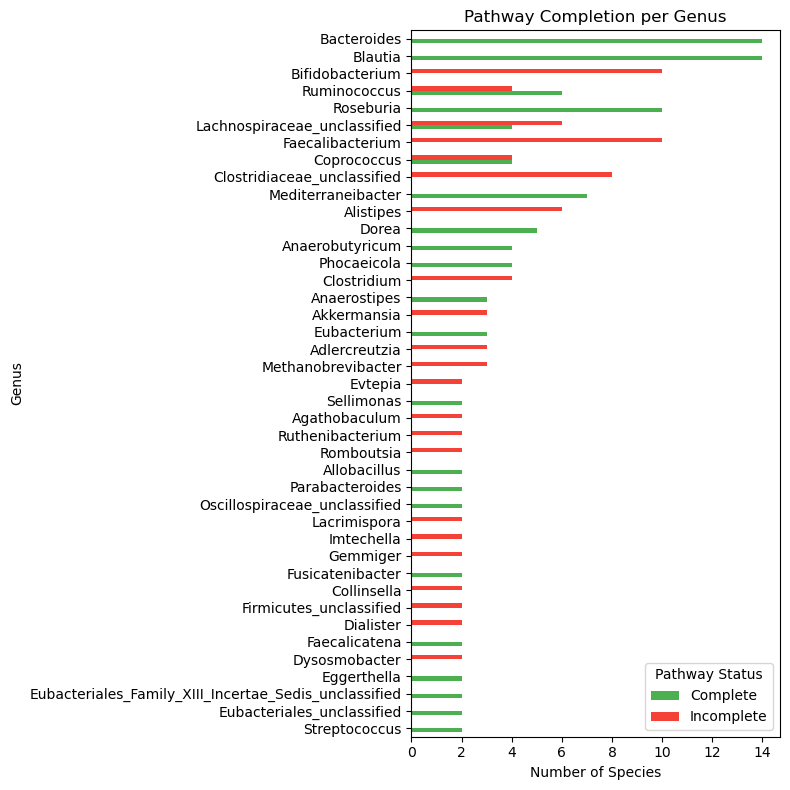

In [83]:
summary_df = summarize_genus_completion(ctrl_taxa_completeness)
plot_genus_completion_horizontal(summary_df)

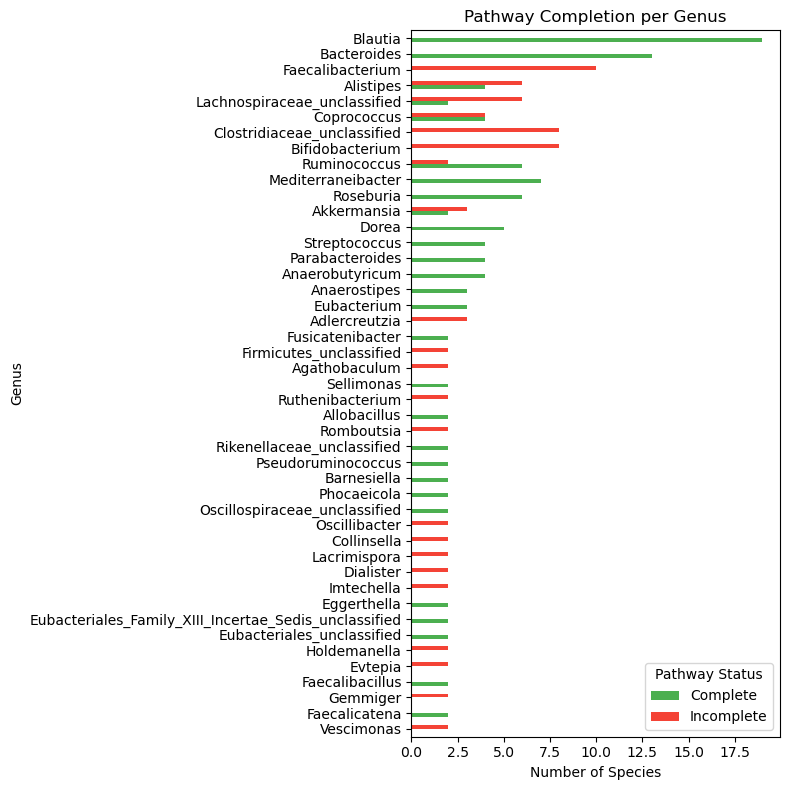

In [79]:
summary_df = summarize_genus_completion(asd_taxa_completeness)
plot_genus_completion_horizontal(summary_df)

In [80]:
stacked_bar_multiple_group(combine_taxa,level="genus", top_n=15)


KeyError: 'Status'

In [16]:
top_asd = pd.read_csv("../data/processed/top_species_ASD.tsv", sep="\t")
top_ctrl = pd.read_csv("../data/processed/top_species_Control.tsv", sep="\t")
top_asd_species = top_asd["Species"]
top_ctrl_species = top_ctrl["Species"]

Only in ASD: {'Holdemanella_porci', 'Streptococcus_thermophilus', 'Ruminococcus_SGB4421', 'GGB3304_SGB4367', 'Pseudoruminococcus_massiliensis', 'Akkermansia_sp_KLE1798', 'Bacteroides_intestinalis', 'Oscillibacter_sp_ER4', 'Rikenellaceae_bacterium', 'Parabacteroides_merdae', 'Faecalibacillus_intestinalis', 'GGB3001_SGB3992', 'Blautia_glucerasea', 'Clostridiaceae_unclassified_SGB15090', 'Blautia_hansenii', 'GGB9184_SGB14123', 'Vescimonas_coprocola', 'Alistipes_SGB2313', 'Alistipes_ihumii', 'Barnesiella_intestinihominis', 'GGB9345_SGB14311', 'Alistipes_shahii', 'GGB9760_SGB15373'}
Only in Control: {'GGB9480_SGB14874', 'Enterocloster_SGB14313', 'Bacteroides_thetaiotaomicron', 'Roseburia_intestinalis', 'Bifidobacterium_catenulatum', 'Faecalibacterium_SGB15315', 'Clostridium_sp_AF36_4', 'Phocaeicola_plebeius', 'Prevotella_SGB1615', 'Catenibacterium_SGB4425', 'Roseburia_sp_AF02_12', 'GGB79890_SGB14770', 'Coprococcus_SGB4669', 'Dysosmobacter_welbionis', 'Methanobrevibacter_smithii', 'Bacteroid

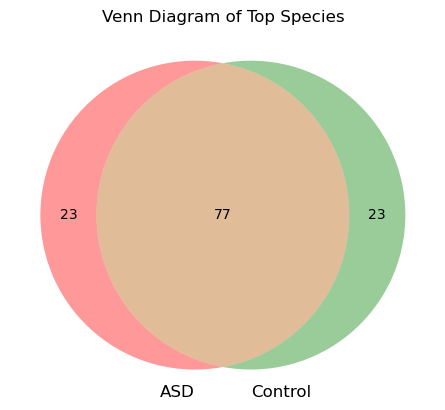

In [17]:

# Two example lists
list1 = top_asd_species
list2 = top_ctrl_species

# Convert to sets
set1 = set(list1)
set2 = set(list2)

# Compute set differences and intersection
only_in_1 = set1 - set2
only_in_2 = set2 - set1
in_both = set1 & set2

# Print elements
print("Only in ASD:", only_in_1)
print("Only in Control:", only_in_2)
print("In Both Lists:", in_both)

# Plot the Venn diagram
venn2([set1, set2], set_labels=('ASD', 'Control'))
plt.title("Venn Diagram of Top Species")
plt.show()

